In [1]:
import zipfile
import os
import random
import shutil
import matplotlib.pyplot as plt
import shutil
import random
import tensorflow as tf
from PIL import Image
from google.colab import drive
import matplotlib.image as mpimg
from tensorflow.keras.applications.inception_v3 import InceptionV3

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np



In [2]:
import tensorflow_datasets as tfds

In [3]:
# Mount Drive into Collab

drive.mount('/content/gdrive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

%cd /content/gdrive/My Drive/Kaggle

Mounted at /content/gdrive
/content/gdrive/My Drive/Kaggle


In [ ]:
# Download the Datasets

!kaggle datasets download -d vbookshelf/rice-leaf-diseases

 87% 32.0M/36.7M [00:00<00:00, 94.8MB/s]
100% 36.7M/36.7M [00:00<00:00, 79.8MB/s]


In [ ]:
# Extract the archive
local_zip = './rice-leaf-diseases.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./')
zip_ref.close()

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders

# Define the source and destination directories
source_folder = './rice_leaf_diseases'
output_folder = './rice_leaf_diseases'

# Split the data into train (70%), validation (30%)
splitfolders.ratio(source_folder, output=output_folder, seed=42, ratio=(0.8, 0.2), group_prefix=None)

Copying files: 120 files [00:01, 109.79 files/s]


In [4]:
# Initializing the path of images

baseDir = './rice_leaf_diseases/'
trainDir = './rice_leaf_diseases/train'
valDir = './rice_leaf_diseases/val'
subfolders = ["Leaf smut", "Brown spot", "Bacterial leaf blight"]

In [ ]:
# Count sum Images

leafBlastTrainDir = os.path.join(trainDir, 'Leaf smut')
brownSpotTrainDir = os.path.join(trainDir, 'Brown spot')
BacterialTrainDir = os.path.join(trainDir, 'Bacterial leaf blight')

leafBlastValDir = os.path.join(valDir, 'Leaf smut')
brownSpotValDir = os.path.join(valDir, 'Brown spot')
BacterialValDir = os.path.join(valDir, 'Bacterial leaf blight')

In [ ]:
# Count the Sum of Images

lenBrownSpotTrain = len(os.listdir(brownSpotTrainDir))
lenBacterialTrain = len(os.listdir(BacterialTrainDir))
lenLeafBlastTrain = len(os.listdir(leafBlastTrainDir))
lenBrownSpotVal = len(os.listdir(brownSpotValDir))
lenBacterialVal = len(os.listdir(BacterialValDir))
lenLeafBlastVal = len(os.listdir(leafBlastValDir))
sumAllImages =  lenBrownSpotTrain+lenBacterialTrain+lenLeafBlastTrain+lenBrownSpotVal+lenBacterialVal+lenLeafBlastVal

print('total training brown spot images:\t', lenBrownSpotTrain)
print('total training hispa images:\t\t', lenBacterialTrain)
print('total training leaf blast images:\t', lenLeafBlastTrain, '\n')

print('total validation brown spot images:\t', lenBrownSpotVal)
print('total validation hispa images:\t\t', lenBacterialVal)
print('total validation leaf blast images:\t', lenLeafBlastVal, '\n')

print('total all images:\t\t\t',  sumAllImages)
print('total training images:\t\t\t', lenBrownSpotTrain+lenBacterialTrain+lenLeafBlastTrain)
print('total training in percent:\t\t', (lenBrownSpotTrain+lenBacterialTrain+lenLeafBlastTrain)/sumAllImages*100, '%')
print('total validation images:\t\t', lenBrownSpotVal+lenBacterialVal+lenLeafBlastVal)
print('total validation in percent:\t\t', (lenBrownSpotVal+lenBacterialVal+lenLeafBlastVal)/sumAllImages*100, '%')

img_path = os.path.join(brownSpotTrainDir, os.listdir(brownSpotTrainDir)[0])
img = mpimg.imread(img_path)
print('image shape:\t\t\t\t', img.shape)

total training brown spot images:	 32
total training hispa images:		 32
total training leaf blast images:	 32 

total validation brown spot images:	 8
total validation hispa images:		 8
total validation leaf blast images:	 8 

total all images:			 120
total training images:			 96
total training in percent:		 80.0 %
total validation images:		 24
total validation in percent:		 20.0 %
image shape:				 (127, 316, 3)


IndexError: ignored

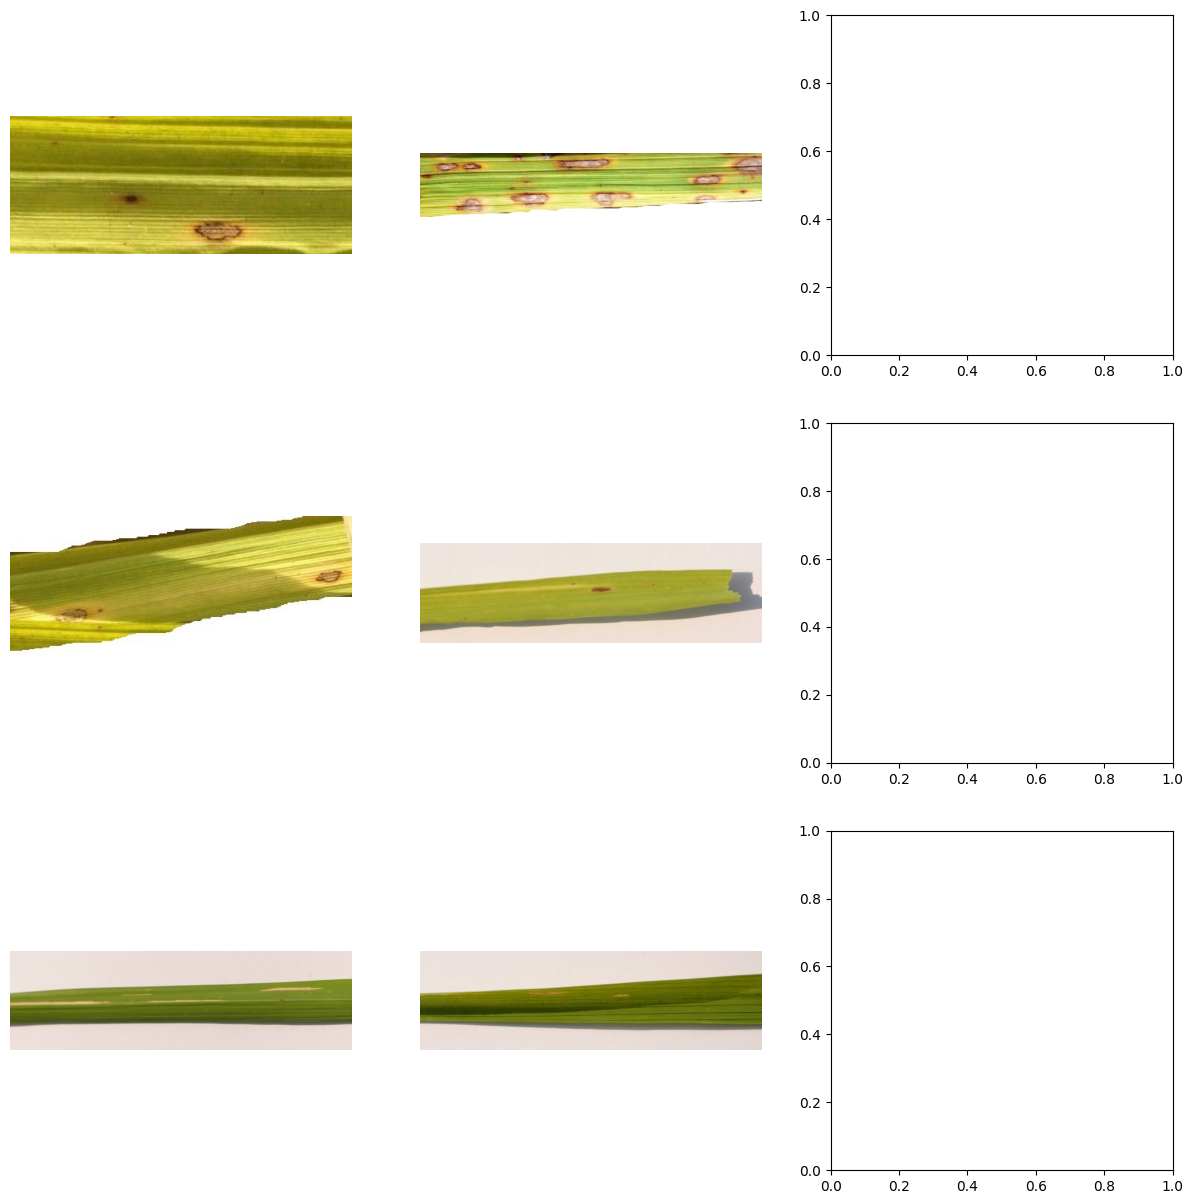

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

nextBrownSpotTrain = [os.path.join(brownSpotTrainDir, fname)
                for fname in os.listdir(brownSpotTrainDir)[0:4]]
nextBacterialTrain = [os.path.join(BacterialTrainDir, fname)
                for fname in os.listdir(BacterialTrainDir)[0:4]]
nextLeafBlastTrain = [os.path.join(leafBlastTrainDir, fname)
                for fname in os.listdir(leafBlastTrainDir)[0:4]]

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

for i, img_path in enumerate(nextBrownSpotTrain+nextBacterialTrain+nextLeafBlastTrain):
  img = mpimg.imread(img_path)
  ax = axs[i // 2, i % 2]
  ax.imshow(img)
  ax.axis('off')

plt.tight_layout()
plt.show()

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

training_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	trainDir,
	target_size=(224,224),
  batch_size=32,
	class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
	valDir,
	target_size=(224,224),
  batch_size=32,
	class_mode='categorical'
)

Found 96 images belonging to 3 classes.
Found 24 images belonging to 3 classes.


In [7]:
premodel = tf.keras.applications.DenseNet121(input_shape=(224,224,3),
                                                      include_top=False,
                                                      weights='imagenet')

# premodel.summary()

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
# !wget --no-check-certificate \
#     https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
#     -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

In [ ]:
# local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# inception = InceptionV3(include_top=False,
#                         input_shape=(150, 150, 3),
#                         weights=None)
# inception.load_weights(local_weights_file)

# for layer in inception.layers:
#   layer.trainable= False

# inception.summary()

In [ ]:
# import tensorflow as tf

# model = tf.keras.models.Sequential([
#     # Note the input shape is the desired size of the image 150x150 with 3 bytes color
#     # This is the first convolution
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(224, 224, 3)),
#     tf.keras.layers.MaxPooling2D(2, 2),

#     # The second convolution
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),

#     # # The third convolution
#     # tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
#     # tf.keras.layers.MaxPooling2D(2,2),

#     # # The fourth convolution
#     # tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
#     # tf.keras.layers.MaxPooling2D(2,2),

#     # Flatten the results to feed into a DNN
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dropout(0.5),

#     # 512 neuron hidden layer
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dense(4, activation='softmax')
# ])

# # Print the model summary
# model.summary()

In [ ]:
# last_layer = inception.get_layer('mixed7')
# last_output = last_layer.output

In [8]:
from tensorflow.keras import Model

inputs = premodel.input

x = tf.keras.layers.Flatten()(premodel.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

###################################################################################

# x = tf.keras.layers.Flatten()(last_output)
# x = tf.keras.layers.Dense(1024, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Dense(4, activation='softmax')(x)

# model = Model(inception.input, x)

###################################################################################

# model = tf.keras.models.Sequential([
#     # Note the input shape is the desired size of the image 150x150 with 3 bytes color
#     # This is the first convolution
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     # The second convolution
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     # The third convolution
#     tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     # The fourth convolution
#     tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     # Flatten the results to feed into a DNN
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dropout(0.5),
#     # 512 neuron hidden layer
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dense(4, activation='softmax')
# ])

# model.summary()

In [16]:
# Set the training parameters
model.compile(loss = 'categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

In [17]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, log={}):
    if(log.get('accuracy')>0.99) and (log.get('val_accuracy')>0.99):
      self.model.stop_training = True
      print('\nThe accuracy has reached  > 99%')

callback = myCallback()

In [18]:
# Train the model
history = model.fit(train_generator, epochs=100, validation_data = validation_generator, callbacks=[callback])

Epoch 1/100
3/3 [==============================] - 61s 2s/step - loss: 0.0475 - accuracy: 0.9792 - val_loss: 2.6064 - val_accuracy: 0.7917
Epoch 2/100
3/3 [==============================] - 3s 1s/step - loss: 0.0575 - accuracy: 0.9792 - val_loss: 4.6191 - val_accuracy: 0.7500
Epoch 3/100
3/3 [==============================] - 3s 1s/step - loss: 0.0800 - accuracy: 0.9792 - val_loss: 2.5741 - val_accuracy: 0.7500
Epoch 4/100
3/3 [==============================] - 4s 2s/step - loss: 0.0175 - accuracy: 0.9896 - val_loss: 1.7321 - val_accuracy: 0.7917
Epoch 5/100
3/3 [==============================] - 4s 1s/step - loss: 0.1055 - accuracy: 0.9688 - val_loss: 1.4431 - val_accuracy: 0.7500
Epoch 6/100
3/3 [==============================] - 4s 1s/step - loss: 0.0917 - accuracy: 0.9792 - val_loss: 0.9037 - val_accuracy: 0.7917
Epoch 7/100
3/3 [==============================] - 3s 1s/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.6273 - val_accuracy: 0.7917
Epoch 8/100
3/3 [================

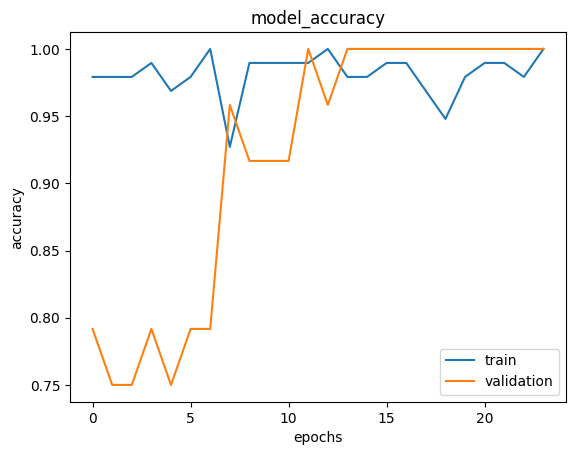

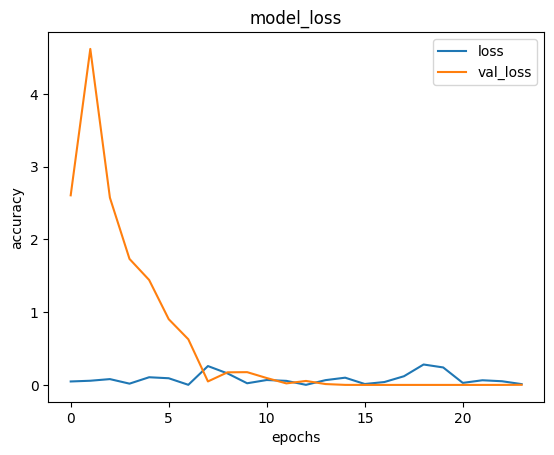

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['loss', 'val_loss'])
plt.show()

In [29]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

classes = ["Bacterial leaf blight", "Brown spot", "Leaf smut"]

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  img = load_img(path, target_size=(224, 224))
  x = img_to_array(img) / 255.0
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  output = model.predict(images)
  best_index = np.argmax(output)
  print(fn)
  print(output)
  print(classes[best_index])

Saving DSC_0403.JPG to DSC_0403.JPG
1/1 [==============================] - 0s 31ms/step
DSC_0403.JPG
[[1.0000000e+00 2.0060569e-22 1.3414806e-22]]
Bacterial leaf blight


In [30]:
!mkdir -p saved_model_h5
model.save('saved_model_h5/saved_model_2_fix_100%.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
